In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [29]:
batch_size = 64

# image_classes = ['cored', 'diffuse', 'CAA']

metrics = {'train': {}, 'validaiton': {}, 'test': {}}

In [6]:
train_n_validation = pd.read_csv(os.path.join(cfg.csv_dir, 'train_n_validation_multilabel.csv'))
test = pd.read_csv(os.path.join(cfg.csv_dir, 'test_multilabel.csv'))

In [7]:
np.random.seed(42)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
src_test = (ImageList.from_df(path=cfg.img_path_test, df=test, folder='hold-out')
       .split_none()
       .label_from_df(label_delim=' '))

In [8]:
data_test = (src_test.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
resnet = models.resnet50
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data_test, resnet, metrics=[acc_05, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.7MB/s]


In [9]:
model_name = 'stage-8-256-rn50'

In [10]:
learn = learn.load(os.path.join(cfg.models_dir, model_name))

In [11]:
learn.data.valid_dl = data_test.train_dl
learn.validate(metrics=[acc_05, f_score])

[0.05349272, tensor(0.9823), tensor(0.9739)]

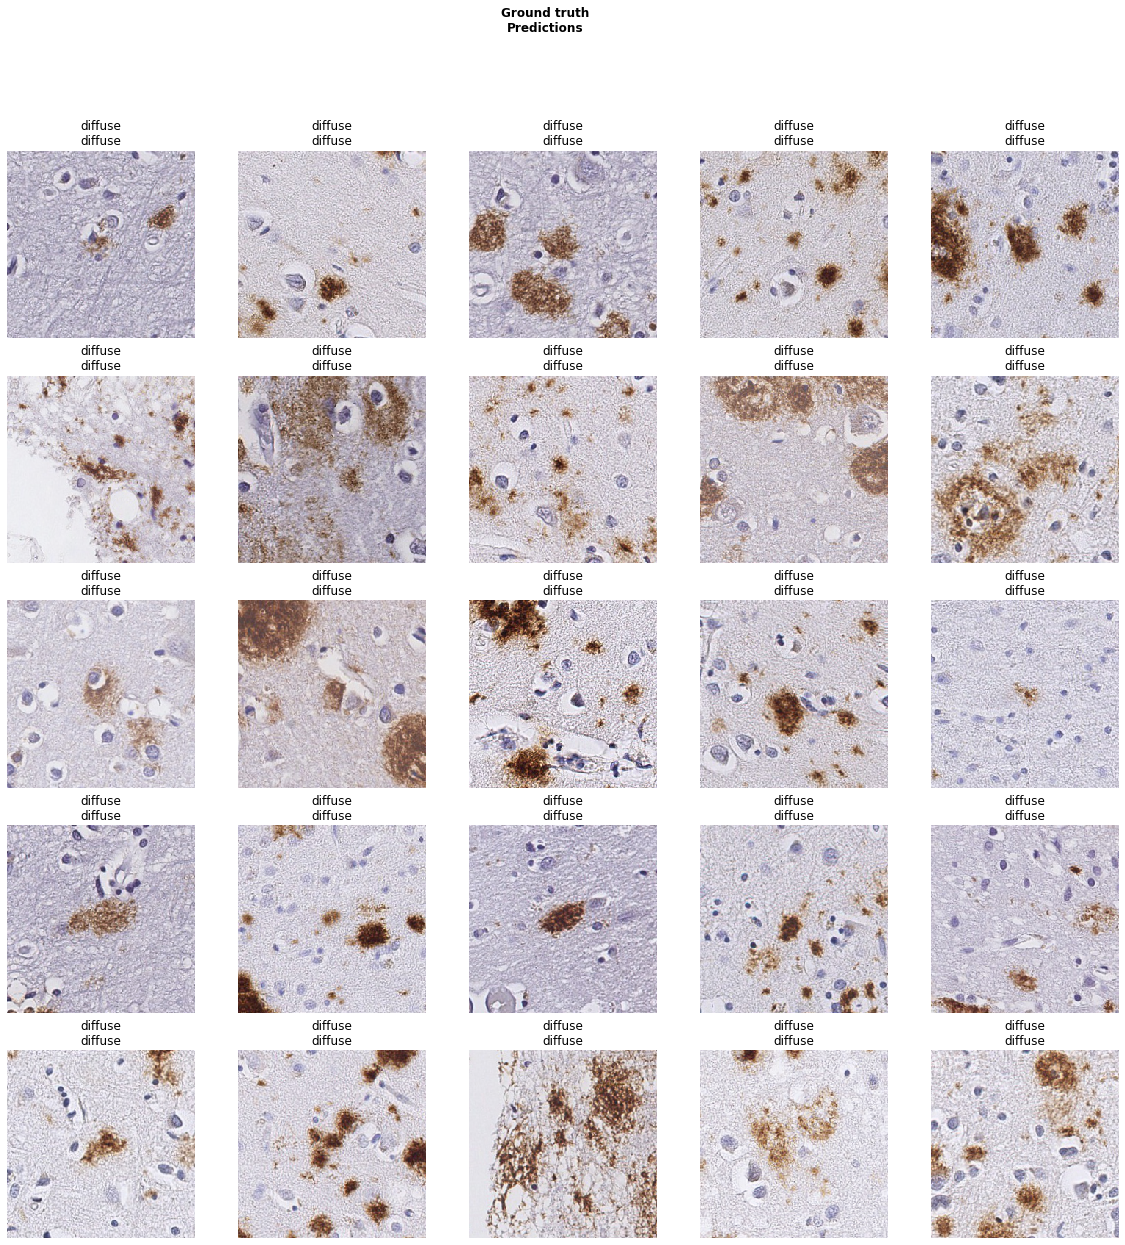

In [12]:
learn.show_results()

In [13]:
preds, y, losses = learn.get_preds(with_loss=True)

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    fig = plt.figure(figsize=(1.2*size, size))
    ax = plt.axes()
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())
        lw = 0.2*size
        # Plot all ROC curves
        ax.plot([0, 1], [0, 1], 'k--', lw=lw, label='random')
        ax.plot(fpr, tpr,
                 label='ROC-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(fpr, tpr)),
                  color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)
       
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=1.8*size)
    ax.set_ylabel('True Positive Rate', fontsize=1.8*size)
    ax.set_title('Receiver operating characteristic Curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc=0, fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

    
def plot_prc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    
    fig = plt.figure(figsize=(1.2*size,size))
    ax = plt.axes()
    
    for i in range(preds.shape[1]):
        rp = (label[:,i]>0).sum()/len(label)
        precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
        
        lw=0.2*size
    
        ax.plot(recall, precision,
                 label='PR-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(recall, precision)),
                 color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)

        ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
   
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=1.8*size)
    ax.set_ylabel('Precision', fontsize=1.8*size)
    ax.set_title('Precision-Recall curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc="lower left", bbox_to_anchor=(0.01, 0.1), fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

saved
saved


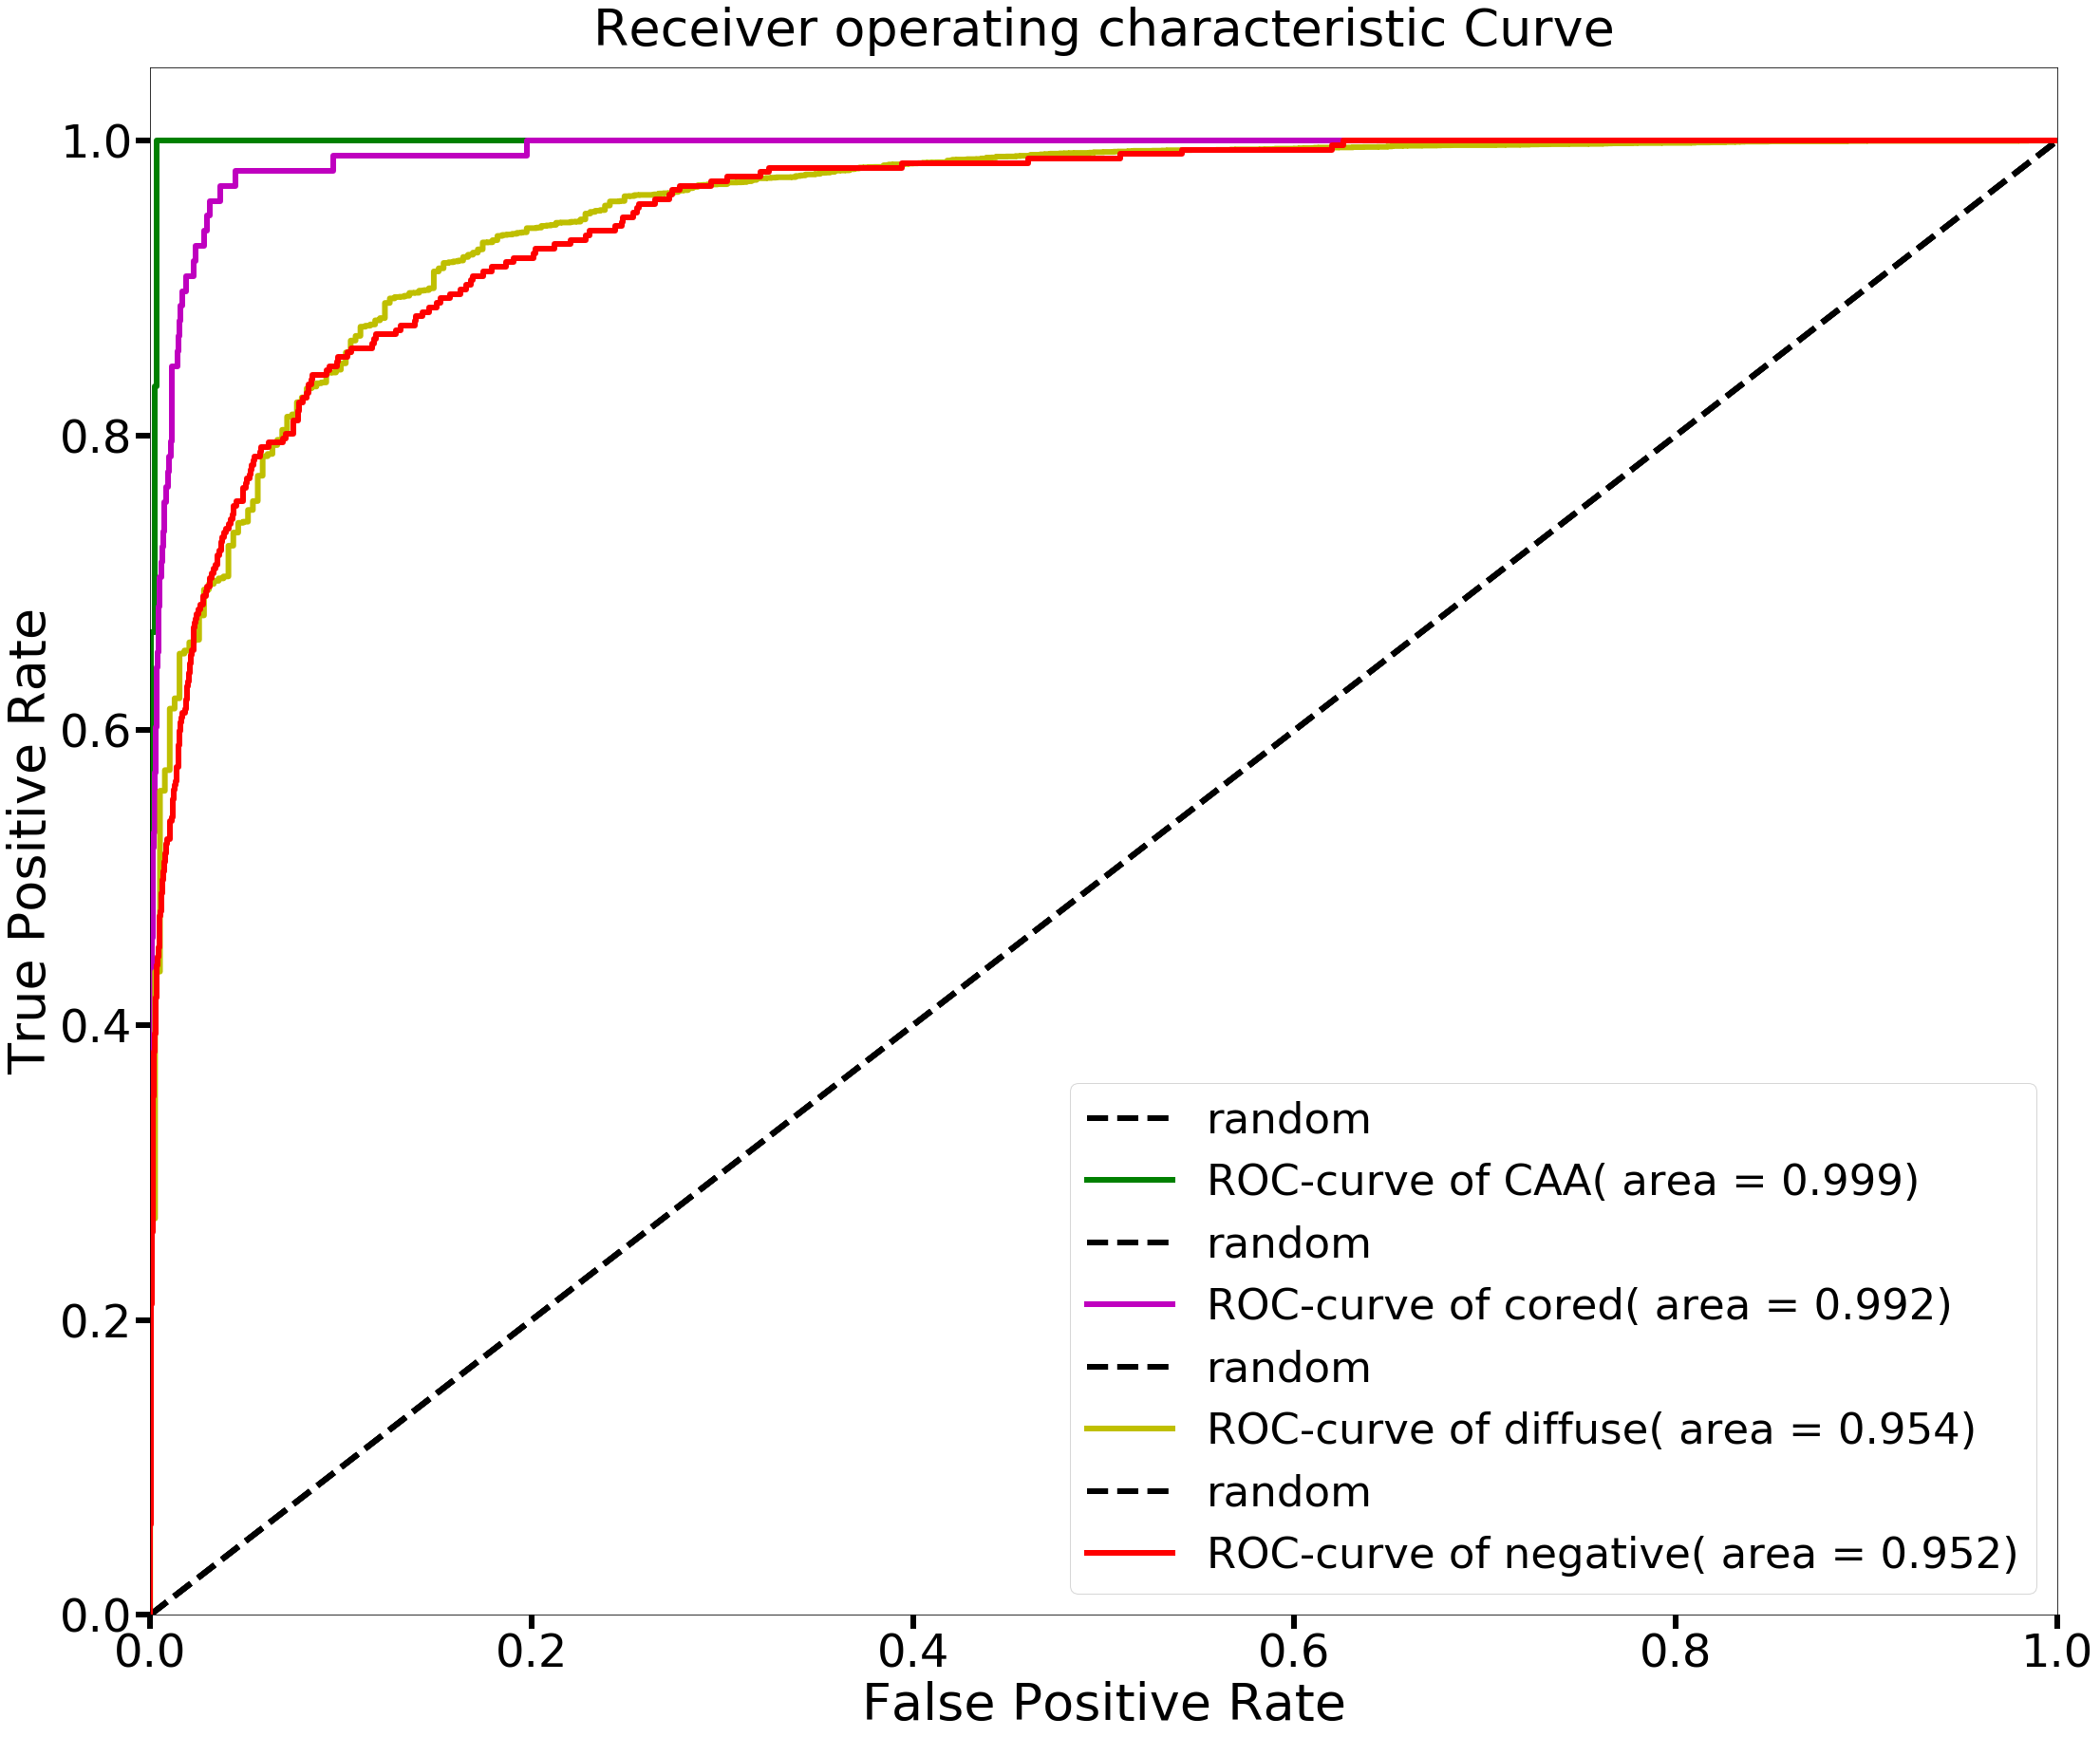

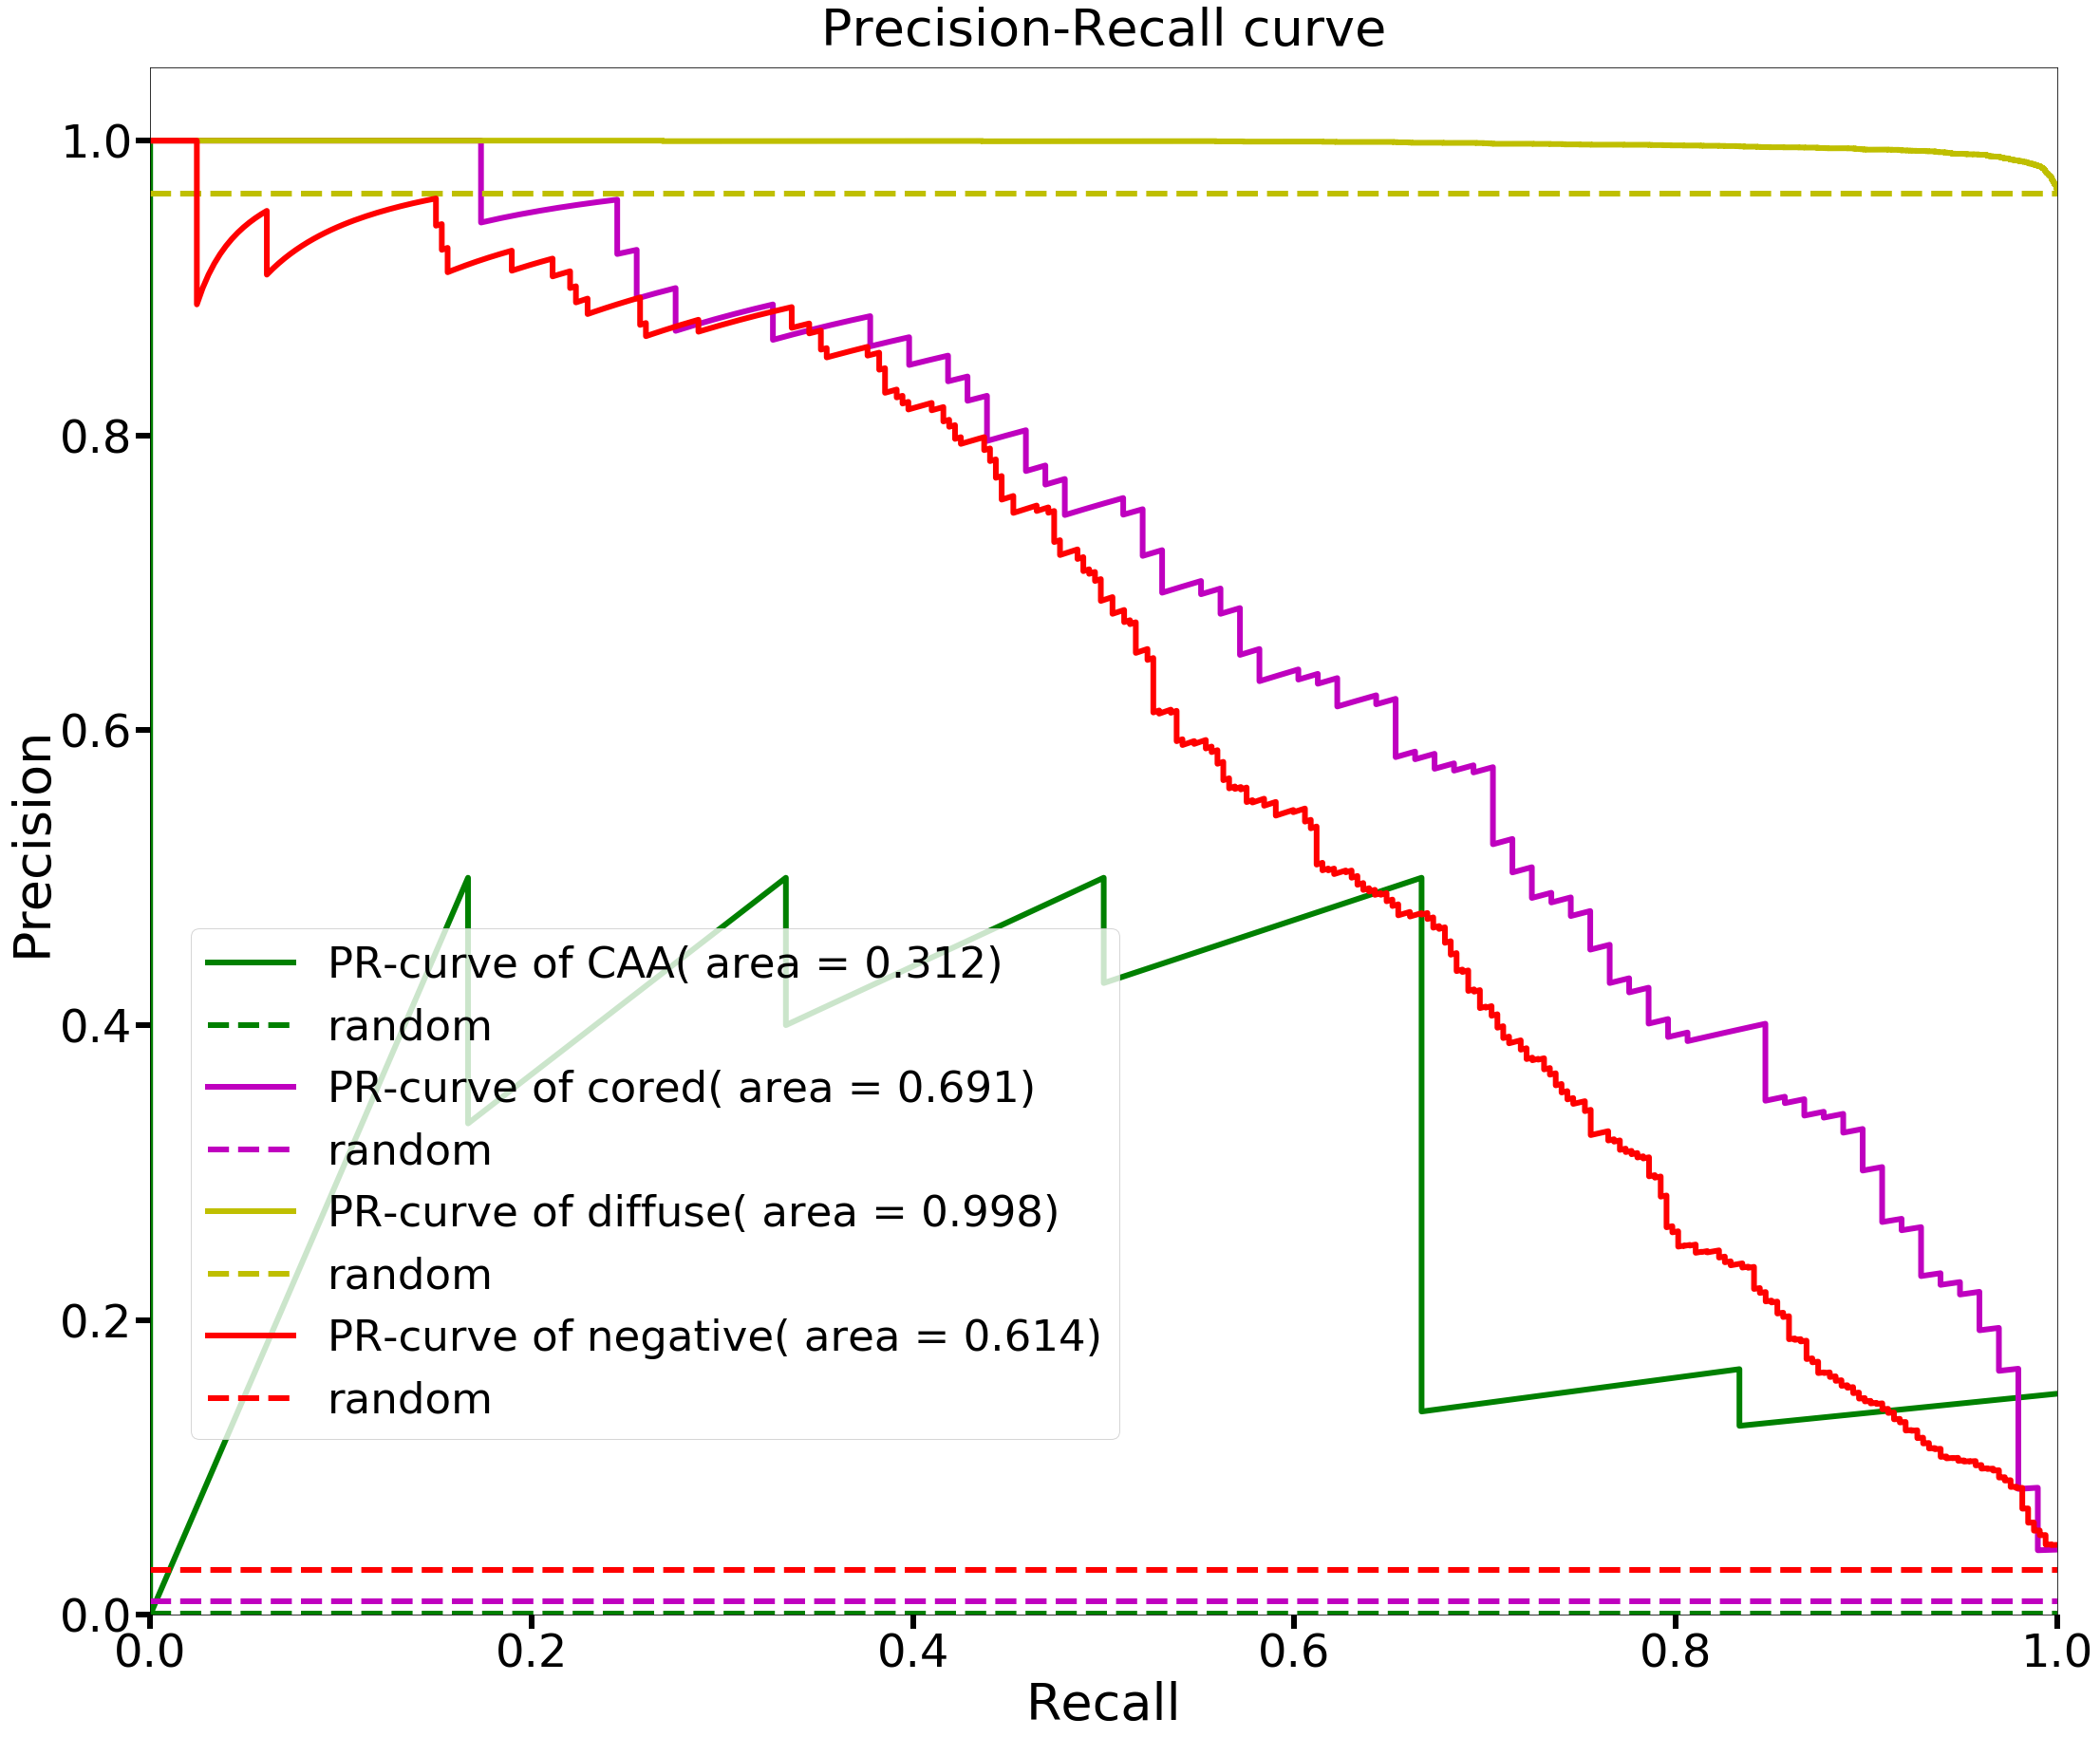

In [15]:
plot_roc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_roc_plot.png'))
plot_prc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_prc_plot.png'))

In [16]:
l = losses.numpy()
losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/4), 4)), columns=learn.data.classes)
losses_df

,CAA,cored,diffuse,negative
0,2.385867e-03,2.023675e-03,0.105851,0.090617
1,5.304673e-05,4.291442e-05,0.133820,0.144921
2,3.337855e-06,3.356370e-04,0.016328,0.010577
3,4.801789e-04,1.192093e-07,0.014005,0.009476
4,1.192093e-07,5.960463e-07,0.001500,0.001891
...,...,...,...,...
10811,2.026556e-06,4.839780e-05,0.002694,0.001975
10812,2.706014e-05,6.006879e-03,0.012101,0.010924
10813,7.474143e-05,1.418580e-05,0.001132,0.007721
10814,3.194758e-05,6.287505e-04,0.066652,0.073403


In [116]:
def losses_reshape(losses, classes=[]):
    l = losses.numpy()
    n_classes = len(classes)
    losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/n_classes), n_classes)),
                             columns=classes)
    return(losses_df)

def get_top_agg_losses(df, n=10, target_class=None):
    
    if not target_class:
        target_class = 'loss'
    
    df['loss'] = pd.DataFrame(df.sum(axis=1), columns=['loss'])
    df = df.sort_values([target_class], ascending=False)
    
    return(df.iloc[0:n])

def plot_top_losses(preds=None,
                    y=None,
                    losses=None,
                    learner=None,
                    target_class=None,
                    n=10,
                    figsize=(256,256)):
    classes=learn.data.classes
    losses_df = losses_reshape(losses, classes=classes)
    losses_df = get_top_agg_losses(losses_df, n=n, target_class=target_class)
    preds_df = pd.DataFrame(preds.numpy(), columns=classes)
    y_df = pd.DataFrame(y.numpy(), columns=classes)
    classes_str = ', '.join(classes)
    
    fig, ax = plt.subplots(n)
    i = 0
    for index_i in losses_df.index:
        imag = learner.data.valid_ds[index_i][0]
        predictions =', '.join(["{0:.4f}".format(x) for x in preds_df.iloc[index_i].values])
        actuals = ', '.join(["{}".format(x) for x in y_df.iloc[index_i].values])
        title = f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}"""
#         imag.show(ax=ax[col_i][row_i], title=title)
#         plt.imshow(imag)
        ax[i].imshow(imag)
        ax[i].set_title(title)
#         imag.set_title(f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}""",
#                         loc='left')
    plt.show()
        
    
    return(losses_df)
    
    
    

TypeError: Image data of dtype object cannot be converted to float

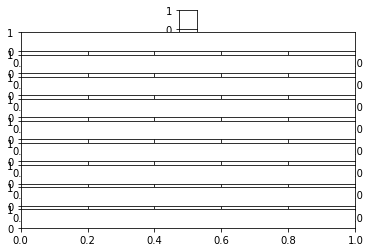

In [117]:
plot_top_losses(preds=preds,
                y=y,
                losses=losses,
                learner=learn,
                target_class='cored')

In [ ]:
y = y.numpy()
ppreds.numpy()

In [49]:
from sklearn.metrics import accuracy_score
threshold = 0.5
metrics['test'][f'accuracy_overall_@threshold_{threshold}'] = accuracy_score(y, preds > threshold)

In [50]:
for class_idx in range(0, len(learn.data.classes)):
    name = f'accuracy_{learn.data.classes[class_idx]}_@threshold_{threshold}'
    metrics['test'][name] = accuracy_score(y[:,class_idx],
                                           preds[:,class_idx] > threshold)

In [59]:
from sklearn.metrics import f1_score
metrics['test'][f'f1_score_overall_@threshold{threshold}'] = f1_score(y, preds > threshold, average='micro')

In [60]:
metrics

{'train': {},
 'validaiton': {},
 'test': {'overall_accuracy': 0.9575628698224852,
  'accuracy_overall_threshold_0.5': 0.9575628698224852,
  'accuracy_cored_threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_threshold_0.5': 0.9689349112426036,
  'accuracy_CAA_threshold_0.5': 0.9975961538461539,
  'accuracy_negative_threshold_0.5': 0.978180473372781,
  'accuracy_overall_@threshold_0.5': 0.9575628698224852,
  'accuracy_CAA_@threshold_0.5': 0.9975961538461539,
  'accuracy_cored_@threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_@threshold_0.5': 0.9689349112426036,
  'accuracy_negative_@threshold_0.5': 0.978180473372781,
  'f1_score_overall_@threshold{threshold}': 0.9646420525081613,
  'f1_score_overall_@threshold0.5': 0.9646420525081613}}

In [62]:
from sklearn.metrics import hamming_loss

metrics['test'][f'hamming_loss_overall_@threshold_{threshold}'] = hamming_loss(y, preds > threshold)

In [63]:
metrics

{'train': {},
 'validaiton': {},
 'test': {'overall_accuracy': 0.9575628698224852,
  'accuracy_overall_threshold_0.5': 0.9575628698224852,
  'accuracy_cored_threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_threshold_0.5': 0.9689349112426036,
  'accuracy_CAA_threshold_0.5': 0.9975961538461539,
  'accuracy_negative_threshold_0.5': 0.978180473372781,
  'accuracy_overall_@threshold_0.5': 0.9575628698224852,
  'accuracy_CAA_@threshold_0.5': 0.9975961538461539,
  'accuracy_cored_@threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_@threshold_0.5': 0.9689349112426036,
  'accuracy_negative_@threshold_0.5': 0.978180473372781,
  'f1_score_overall_@threshold{threshold}': 0.9646420525081613,
  'f1_score_overall_@threshold0.5': 0.9646420525081613,
  'hamming_loss_overall_@threshold0.5': 0.017774593195266274}}